In [1]:
import pandas as pd
import numpy as np
import zipfile

In [30]:
zf = zipfile.ZipFile('data2.zip') 
# if you want to see all files inside zip folder
zf.namelist() 
# now read your csv file 

masterdf = pd.DataFrame()
n = 0

#Iterate through files in zip file
for zipfilename in zf.namelist():
    
    #Read contents of the file
    df = pd.read_csv(zf.open(zipfilename))
    df['departure_date'] = zipfilename[-28:-18]
    #Break up contents into list and process

    masterdf = masterdf.append(df)
    n += 1
masterdf.shape
# df = pd.read_csv(zf.open('masterdf.csv'))

(878, 16)

In [31]:
zf.namelist()[0][-28:-18]
# zf.namelist()[0][-23:-18]

'2022-04-10'

In [32]:
masterdf.drop_duplicates(inplace=True)
masterdf['Price'].describe()

count      857.000000
mean      1725.903151
std       1447.979427
min        873.000000
25%       1016.000000
50%       1105.000000
75%       1662.000000
max      17741.000000
Name: Price, dtype: float64

In [41]:
masterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857 entries, 0 to 45
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Out Time            857 non-null    object
 1   Out Airline         857 non-null    object
 2   Out Cities          857 non-null    object
 3   Out Duration        857 non-null    object
 4   Out Stops           857 non-null    int64 
 5   Out Stop Cities     781 non-null    object
 6   Return Time         857 non-null    object
 7   Return Airline      857 non-null    object
 8   Return Cities       857 non-null    object
 9   Return Duration     857 non-null    object
 10  Return Stops        857 non-null    int64 
 11  Return Stop Cities  734 non-null    object
 12  Price               857 non-null    int64 
 13  timestamp           857 non-null    object
 14  sort                857 non-null    object
 15  departure_date      857 non-null    object
dtypes: int64(3), object(13)
mem

In [33]:
masterdf.head()

,Out Time,Out Airline,Out Cities,Out Duration,Out Stops,Out Stop Cities,Return Time,Return Airline,Return Cities,Return Duration,Return Stops,Return Stop Cities,Price,timestamp,sort,departure_date
0,8:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,27h40m,2,"ATL, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,2,"ICN, BOS",951,20220403-1414,cheap,2022-04-10
1,9:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,26h40m,2,"BOS, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,2,"ICN, BOS",979,20220403-1414,cheap,2022-04-10
2,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,1,NRT,994,20220403-1414,cheap,2022-04-10
3,6:30 am – 12:35 am +2,ANA,EWR‐SIN,30h05m,2,"LAX, NRT",6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,1,NRT,994,20220403-1414,cheap,2022-04-10
4,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,10:10 pm – 9:27 pm +1,ANA,SIN‐EWR,35h17m,2,"HND, ORD",998,20220403-1414,cheap,2022-04-10


In [47]:
time_df = masterdf.set_index(pd.to_datetime(masterdf['departure_date']), drop=True)

time_df = time_df['Price']
time_df

departure_date
2022-04-10     951
2022-04-10     979
2022-04-10     994
2022-04-10     994
2022-04-10     998
              ... 
2022-04-28    1612
2022-04-28    2143
2022-04-28    6805
2022-04-28    2448
2022-04-28    2886
Name: Price, Length: 857, dtype: int64

In [37]:
import matplotlib.pyplot as plt
import matplotlib

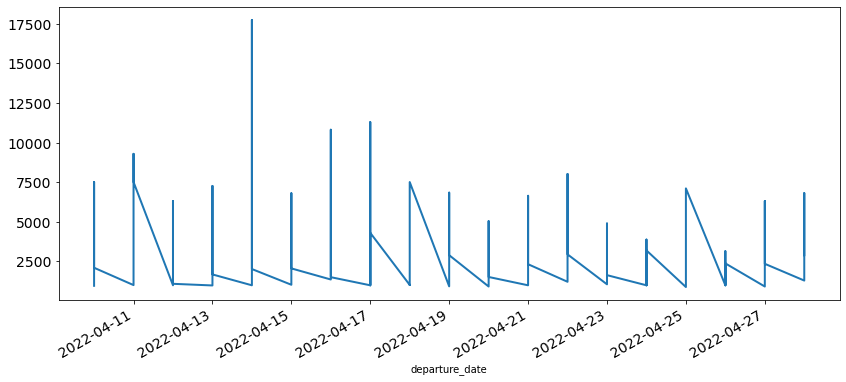

In [48]:
time_df.plot(figsize=(14,6), linewidth=2, fontsize=14);

In [49]:
# importing relevant library
from statsmodels.tsa.stattools import adfuller

# For testing stationarity
def dicky_fuller_test(data):
    alpha = 0.05
    is_stationary = adfuller(data)[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(adfuller(data)[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(adfuller(data)[1],3)}')
    return

In [50]:
dicky_fuller_test(time_df)

The data is stationary with a fuller score of 0.0


In [19]:
# pd.read_csv(zf.open(zf.namelist()[0]))

,Out Time,Out Airline,Out Cities,Out Duration,Out Stops,Out Stop Cities,Return Time,Return Airline,Return Cities,Return Duration,Return Stops,Return Stop Cities,Price,timestamp,sort
0,8:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,27h40m,2,"ATL, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,2,"ICN, BOS",951,20220403-1414,cheap
1,9:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,26h40m,2,"BOS, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,2,"ICN, BOS",979,20220403-1414,cheap
2,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,1,NRT,994,20220403-1414,cheap
3,6:30 am – 12:35 am +2,ANA,EWR‐SIN,30h05m,2,"LAX, NRT",6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,1,NRT,994,20220403-1414,cheap
4,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,10:10 pm – 9:27 pm +1,ANA,SIN‐EWR,35h17m,2,"HND, ORD",998,20220403-1414,cheap
5,11:25 am – 12:35 am +2,United Airlines,EWR‐SIN,25h10m,1,NRT,9:00 am – 5:14 am +1,United Airlines,SIN‐EWR,32h14m,1,SFO,1022,20220403-1414,cheap
6,11:25 am – 12:35 am +2,United Airlines,EWR‐SIN,25h10m,1,NRT,9:00 am – 7:07 am +1,United Airlines,SIN‐EWR,34h07m,1,SFO,1022,20220403-1414,cheap
7,11:25 am – 12:35 am +2,United Airlines,EWR‐SIN,25h10m,1,NRT,9:00 am – 8:29 am +1,United Airlines,SIN‐EWR,35h29m,1,SFO,1022,20220403-1414,cheap
8,10:20 am – 12:35 am +2,United Airlines,EWR‐SIN,26h15m,2,"IAD, NRT",6:10 am – 4:40 pm,"ANA, United Airlines",SIN‐EWR,22h30m,1,NRT,1024,20220403-1414,cheap
9,6:00 am – 12:35 am +2,United Airlines,EWR‐SIN,30h35m,2,"IAD, NRT",6:10 am – 4:40 pm,"ANA, United Airlines",SIN‐EWR,22h30m,1,NRT,1024,20220403-1414,cheap
